In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [208]:
#INCLUDE HEATMAP AND BOXPLOT

In [209]:
# all datasets
df = customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
df = engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
df = marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
df = transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [210]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [211]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [212]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [213]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [214]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [215]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [216]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [217]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level

marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [218]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [219]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [220]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

In [221]:
# now you have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [222]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [223]:
joint_data.describe()

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
count,8991.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7665.000000
mean,43.467467,100.111900,39.862100,19.725300,12.954500,7737.562981,1.640965
std,15.094380,118.625052,46.511719,22.975083,7.191203,4628.799469,0.776240
min,18.000000,1.000000,1.000000,1.000000,1.000000,23.810000,1.000000
25%,30.000000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000
50%,44.000000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000
75%,57.000000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000
max,69.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000


In [ ]:
print("Linear Regression:")
print("Mean Squared Error:", mse_lr)
print("R-squared:", r2_lr)

Linear Regression:
Mean Squared Error: 9.230532645110033e-24
R-squared: 1.0


In [224]:
1.  #data cleaning  and preparation 

1.0

In [225]:
#handling missing values
joint_data.fillna(0, inplace=True)

In [226]:
#drop rows with invalid dates
joint_data = joint_data.dropna(subset=['join_date', 'last_purchase_date'])

In [252]:
#converting 'last_purchase_date' column to datetime
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'], errors='coerce')

In [254]:
#converting 'join_date' column to datetime

joint_data['join_date'] = pd.to_datetime(joint_data['join_date'], errors='coerce')

In [253]:
# converting data types

transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [228]:
# Identify outliers
outliers = joint_data[(joint_data['transaction_amount'] < lower_bound) | (joint_data['transaction_amount'] > upper_bound)]

In [263]:
correlation_matrix = joint_data[['number_of_site_visits', 'transaction_amount']].corr()

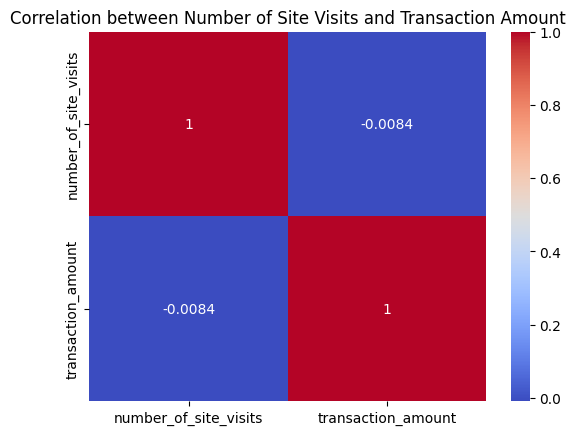

In [266]:
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Number of Site Visits and Transaction Amount')
plt.show()

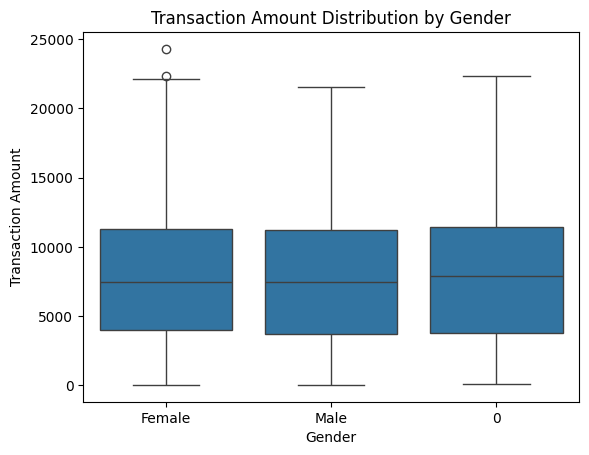

In [267]:
sns.boxplot(x='gender', y='transaction_amount', data=joint_data)
plt.title('Transaction Amount Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Transaction Amount')
plt.show()

In [229]:
#features
features = ['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 
            'transaction_amount', 'recency', 'age', 'gender', 'location', 
        
           ]

#target
target = 'clv'

In [230]:
#features and target
X = joint_data_agg.drop(columns=['customer_id', 'clv'])
y = joint_data_agg['clv']

In [231]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [232]:
# using the IQR method for outlier detection in 'transaction_amount'
Q1 = joint_data['transaction_amount'].quantile(0.25)
Q3 = joint_data['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [233]:
#perform cross-validation with Linear Regression
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')  # Use neg_mean_squared_error for regression

In [234]:
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='r2')

#the cross-validation scores (R-squared values will be between 0 and 1)
print("Cross-validation scores:", scores)
print("Average R-squared:", scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Average R-squared: 1.0


In [235]:
2. #feature engineering

2.0

In [255]:
#agg. total spent per customer

joint_data_agg = joint_data.groupby('customer_id').agg(
    total_spent=pd.NamedAgg(column='transaction_amount', aggfunc='sum')
).reset_index()

#CLV estimation

joint_data_agg['clv'] = joint_data_agg['total_spent']
print(joint_data_agg.head())

   customer_id  total_spent       clv
0            1      3509.48   3509.48
1            2      6081.32   6081.32
2            3      1454.87   1454.87
3            4      7874.68   7874.68
4            5     15524.55  15524.55


In [ ]:
#aggregrate other engagemenr metrics at the customer level

joint_data_agg = joint_data.groupby('customer_id').agg({'recency': 'first', 'frequency': 'first', 'time_as_customer': 'first', 'age': 'first', 'gender': 'first', 'location': 'first', 'location': 'first', 'number_of_site_visits': 'sum', 'number_of_emails_opened': 'sum', 'number_of_clicks': 'sum'}).reset_index()

In [ ]:
#time as customer: duration since joining 

joint_data['time_as_customer'] = (pd.to_datetime('today') - joint_data['join_date']).dt.days

In [ ]:
#renaming columns

marketing.rename(columns={'Response Date ': 'response_date'}, inplace=True)

In [262]:
# calculating the frequency of transactions per customer

joint_data['frequency'] = joint_data.groupby('customer_id')['transaction_id'].transform('count')

In [249]:
# Compute 'frequency' as the number of transactions per customer
joint_data['frequency'] = joint_data.groupby('customer_id')['transaction_id'].transform('count')


In [247]:
#'time_as_customer' as the time difference (in days) between the first and last purchase
joint_data['time_as_customer'] = (pd.to_datetime(joint_data['last_purchase_date']) - 
                                  pd.to_datetime(joint_data['join_date'])).dt.days


In [251]:
#aggregrate
joint_data_agg = joint_data.groupby('customer_id').agg(
    recency=('recency', 'first'), 
    frequency=('frequency', 'first'), 
    time_as_customer=('time_as_customer', 'first'), 
    age=('age', 'first'), 
    gender=('gender', 'first'), 
    location=('location', 'first'), 
    number_of_site_visits=('number_of_site_visits', 'sum'), 
    number_of_emails_opened=('number_of_emails_opened', 'sum'), 
    number_of_clicks=('number_of_clicks', 'sum'),
    total_spent=('transaction_amount', 'sum'),
    avg_transaction_value=('transaction_amount', 'mean')
).reset_index()

In [244]:
#calculating the recency in days

joint_data['recency'] = (pd.to_datetime('today') - joint_data['last_purchase_date']).dt.days

In [ ]:
#calculate purchase frequency per month

transactions['month'] = transactions['transaction_date'].dt.to_period('M')
monthly_purchases = transactions.groupby(['customer_id', 'month'])['transaction_id'].count().reset_index(name='monthly_frequency')
avg_monthly_purchases = monthly_purchases.groupby('customer_id')['monthly_frequency'].mean().reset_index(name='avg_monthly_frequency')

In [ ]:
#calculate average monthly frequency

avg_monthly_purchases = monthly_purchases.groupby('customer_id')['monthly_frequency'].mean()

In [ ]:
#join average monthly purchases to joint_data_agg 

joint_data_agg = joint_data_agg.merge(avg_monthly_purchases, on='customer_id', how='left', suffixes=('', '_avg'))

In [ ]:
#calculate customer age

joint_data['customer_age'] = (pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])).dt.days

In [ ]:
# Identify outliers
outliers = joint_data[(joint_data['transaction_amount'] < lower_bound) | (joint_data['transaction_amount'] > upper_bound)]

In [ ]:
# Check the first few rows of the DataFrame
joint_data_agg.head()

# Check the column names
#print(joint_data_agg.columns)


,customer_id,total_spent,clv
0,1,3509.48,3509.48
1,2,6081.32,6081.32
2,3,1454.87,1454.87
3,4,7874.68,7874.68
4,5,15524.55,15524.55


In [ ]:
#calculating LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [ ]:
nan_counts = df.isna().sum() 
print(nan_counts)

transaction_id        0
customer_id           0
transaction_date      0
transaction_amount    0
product_category      0
dtype: int64


In [ ]:
3. #model training and evaulation

3.0

In [ ]:
# Linear Regression model
linear_model = LinearRegression()

In [ ]:
#creating the Linear Regression model

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
#making predictions 

y_pred_lr = model_lr.predict(X_test)

In [ ]:
#evaluate performance

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [ ]:
print("Linear Regression:")
print("Mean Squared Error:", mse_lr)
print("R-squared:", r2_lr)

Linear Regression:
Mean Squared Error: 9.230532645110033e-24
R-squared: 1.0


In [ ]:
# creating the RandomForestRegresor and fit the model

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust n_estimators as needed
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
#make predictions

y_pred_rf = model_rf.predict(X_test)

In [ ]:
#evaluate performance

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest:")
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)


Random Forest:
Mean Squared Error: 4.528676389090562
R-squared: 0.9999997799304164


In [ ]:
#create the KNN Regression model

model_knn = KNeighborsRegressor(n_neighbors=5)  
model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
#make predictions

y_pred_knn = model_knn.predict(X_test)

In [ ]:
#evaluate performance

mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Regression:")
print("Mean Squared Error:", mse_knn)
print("R-squared:", r2_knn)

KNN Regression:
Mean Squared Error: 9.522008106000007
R-squared: 0.9999995372810555


In [ ]:
#create XGboost model

scores_xgb = cross_val_score(model_xgb, X, y, cv=5, scoring='neg_mean_squared_error')

print("\nXGBoost Cross-Validation Scores (Negative MSE):", scores_xgb)
print("Average MSE:", -scores_xgb.mean())


XGBoost Cross-Validation Scores (Negative MSE): [-5068.23442434 -1437.79904902 -2799.24813944 -8788.73733325
 -2459.50107565]
Average MSE: 4110.704004339663


In [ ]:
4. # model evaluation 

4.0

In [ ]:
#evaluate Linear Regression

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)  # Root Mean Squared Error
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

C:\Users\rsand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#evaluate Random Forest

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

C:\Users\rsand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#evaluate XGBoost

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

C:\Users\rsand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#evaluate KNN Regression

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

C:\Users\rsand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#print results

print("Model Evaluation:")
print("\nLinear Regression:")
print("MSE:", mse_lr, " RMSE:", rmse_lr, " MAE:", mae_lr, " R-squared:", r2_lr)
print("\nRandom Forest:")
print("MSE:", mse_rf, " RMSE:", rmse_rf, " MAE:", mae_rf, " R-squared:", r2_rf)
print("\nXGBoost:")
print("MSE:", mse_xgb, " RMSE:", rmse_xgb, " MAE:", mae_xgb, " R-squared:", r2_xgb)
print("\nKNN Regression:")
print("MSE:", mse_knn, " RMSE:", rmse_knn, " MAE:", mae_knn, " R-squared:", r2_knn)


Model Evaluation:

Linear Regression:
MSE: 9.230532645110033e-24  RMSE: 3.038179166064772e-12  MAE: 2.5353781296644228e-12  R-squared: 1.0

Random Forest:
MSE: 4.528676389090562  RMSE: 2.128068699335283  MAE: 0.9826098499996748  R-squared: 0.9999997799304164

XGBoost:
MSE: 1666.8171468496782  RMSE: 40.82667200311187  MAE: 20.746043427734374  R-squared: 0.999919001552796

KNN Regression:
MSE: 9.522008106000007  RMSE: 3.085775122396317  MAE: 1.5809849999999837  R-squared: 0.9999995372810555


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [ ]:
# Linear Regression
linear_model = LinearRegression()
rmse_linear, r2_linear = evaluate_model(linear_model, X_train, X_test, y_train, y_test)

# Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)
rmse_tree, r2_tree = evaluate_model(tree_model, X_train, X_test, y_train, y_test)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rmse_rf, r2_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
rmse_gb, r2_gb = evaluate_model(gb_model, X_train, X_test, y_train, y_test)

# Support Vector Regressor
svr_model = SVR(kernel='rbf')
rmse_svr, r2_svr = evaluate_model(svr_model, X_train, X_test, y_train, y_test)

In [ ]:
# Store results in a dictionary
results = {
    'Linear Regression': {'RMSE': rmse_linear, 'R²': r2_linear},
    'Decision Tree Regressor': {'RMSE': rmse_tree, 'R²': r2_tree},
    'Random Forest Regressor': {'RMSE': rmse_rf, 'R²': r2_rf},
    'Gradient Boosting Regressor': {'RMSE': rmse_gb, 'R²': r2_gb},
    'Support Vector Regressor': {'RMSE': rmse_svr, 'R²': r2_svr}
}

In [ ]:
# Print the results
for model_name, metrics in results.items():
    print(f"{model_name} RMSE: {metrics['RMSE']}, R²: {metrics['R²']}")


Linear Regression RMSE: 3.038179166064772e-12, R²: 1.0
Decision Tree Regressor RMSE: 3.160500609080818, R²: 0.999999514599197
Random Forest Regressor RMSE: 2.128068699335283, R²: 0.9999997799304164
Gradient Boosting Regressor RMSE: 37.35831914039368, R²: 0.9999321791248718
Support Vector Regressor RMSE: 2791.1041137111115, R²: 0.6214346963229979


In [ ]:
# Find the model with the lowest RMSE
best_model_rmse = min(results, key=lambda x: results[x]['RMSE'])
print(f"The best model based on RMSE is: {best_model_rmse} with RMSE: {results[best_model_rmse]['RMSE']}")

# Find the model with the highest R²
best_model_r2 = max(results, key=lambda x: results[x]['R²'])
print(f"The best model based on R² is: {best_model_r2} with R²: {results[best_model_r2]['R²']}")


The best model based on RMSE is: Linear Regression with RMSE: 3.038179166064772e-12
The best model based on R² is: Linear Regression with R²: 1.0


In [ ]:
#calculating LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64